# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Pitch scaling and time stretching</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.io import wavfile
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal
import import_ipynb
from Helpers import *
import matplotlib
from IPython.display import IFrame

figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})
fs=44100

importing Jupyter notebook from Helpers.ipynb


In this notebook, we will explore the possibilities of modifiying a recording's duration and pitch. Pitch and duration are two correlated concepts that are essential in the shape of sound. In many contexts, it is interesting to be able to change the pitch or the duration of a recording, and this independently of each other. For instance, changing the pitch of a recording allows to transpose it to a different key (finer pitch edits lead to Autotune, an (in)famous effect for rectifying the pitch of a singing voice). Similarly, changing the duration of a recording can be useful for correcting off-beat and precision problems of for instance, the lead vocals.

In this notebook, we will implement several increasingly complex (and efficient) algorithms for changing the duration or the pitch of a recording, using a tool called the **phase vocoder**. This notebook should be regarded as an extension of [the **VoiceTransformer** notebook for the COM-303 DSP class taught by Dr. Paolo Prandoni](https://github.com/prandoni/COM303/blob/master/VoiceTransformer/VoiceTransformer.ipynb).

## 1. Pitch control

Let's start with a quick reminder of how pitch and duration work together and are naturally dependent on each other. A sound wave, either analog or digital, has the property that if it is played faster (with a shorter duration), the pitch is going to go higher. This phenomenon could be easily experienced analogly with vinyl turntables, by playing a 33RPM record at 45 RPM, for instance. The whole tempo of the song would be faster, but the instruments and the voice would also go up, and sound like a chipmunk version of the original. The opposite effect would slow-down the song and make it sound low (and dometimes surprisingly interesting).

In [2]:
IFrame(src="https://www.youtube.com/watch?v=doz1QJ7LwjA", width="560", height="315", frameborder="0", allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture")

Let's now look at a digital example: to straight-forward way to change the duration of a sound is to change the sampling rate at which it is read. For this, we can simply resample the sound at a different rate while playing it at the same rate. This is called **pitch control**. Let's implement this quickly.

In [3]:
def pitch_control(x, r):
    """Simple pitch control.
    
    x: input signal
    r: ratio of the time and pitch modification
    """
    return signal.resample(x, int(x.size/r))

Let's now import a voice sample, that we are going to use for testing each of our algorithms.

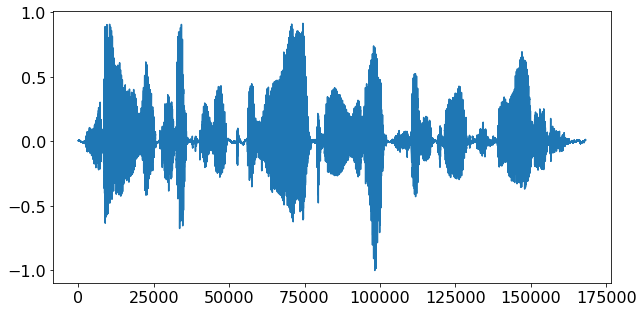

In [4]:
speech_sample = open_audio("samples/speech.wav")
Audio("samples/speech.wav", autoplay=False)

We now reduce the speed (and so the pitch) by 60% for the original. We plot a STFT of both signals together. We can notice that on the pitch controlled STFT, the signal is both stretched horinzontally and crushed vertically.

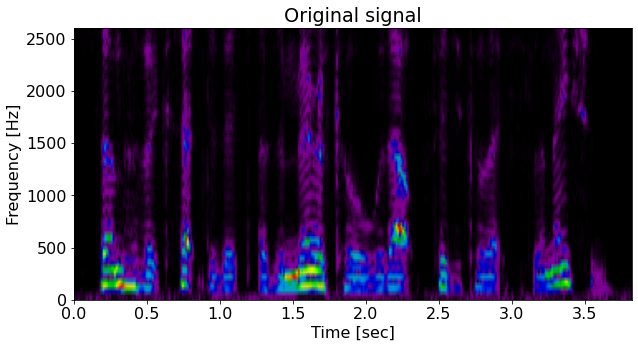

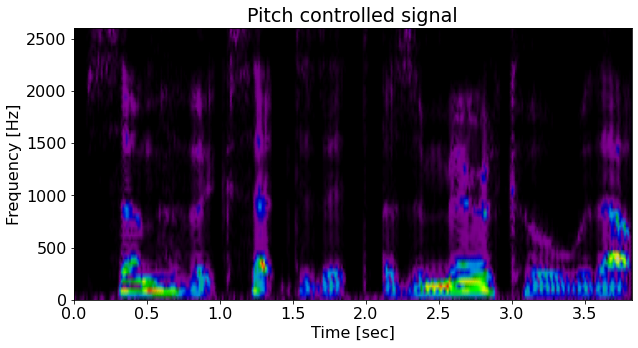

In [5]:
speech_control = pitch_control(speech_sample, 0.6)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("speech_STFT.png", dpi=150, bbox_inches='tight')
plt.show()

f, t, Zxx = signal.stft(speech_control[:speech_sample.size], fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch controlled signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("pitch_control.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_control, "samples/speech_control.wav")

## 2. OLA

To sum up, pitch control is fun, but not really useful in practice. What is interesting is to be able to change the duration of the audio, while keeping the pitch unchanged (or the opposite). One easy way to do this is called **Overlap and Add (OLA)**. It is a time domain algorithm, meaning that no FFT is needed. The concept is simple. We first decompose the signal into chunks of fixed lenght using a window. The Hamming window is generally a popular choice because it includes overlapping between the chunks, which makes the transition between a chunk to the next smoother. To change the duration of the audio recording, we simply change the amount of overlapping.

The time difference between the start of the windows is called the **hop size**. To achieve OLA time stretching, one hence simply changes the hop size.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8a/GeneralizedPrinciple_TSM.png" alt="Drawing" style="width: 65%;"/>

### 2.1 Time stretching

Let's now implement a simple OLA time stretching algorithm. It takes as input the signal, the ratio of time modification, the size of the window (a Hanning window), and the analysis hop size (as in the picture above). The synthesis hop size is computed automatically using the time modification ratio.

In [6]:
def OLA_stretch(x, r, w=2048, h_in=1024):
    """Time strech using Overlap-and-add (OLA)
    x: input signal
    r: time modification ratio
    w: window size
    h_in: input (analysis) hop size (# samples between 2 windows' start times)
    """
    hanning_window = np.hanning(w) # We use a hanning window
    result = np.zeros( int(x.size /r + w) ) # Output placeholder

    for i in np.arange(0, x.size-(w+h_in), int(h_in*r)): # Windowing the signal with input hop size
        chunk = x[i: i + w] # Get one chunk
        h_out = int(i/r) # Set different output hop size
        result[h_out : h_out + w] += hanning_window * chunk # Add this window to result with output hop size

    return result / np.max(np.abs(result) ) # Normalize

Let's now test this algorithm on the voice sample. The pitch is now unchanged! We can look at the STFT plot. This time, the OLA version is stretched horizontally but the vertical axis is untouched, meaning that the pitch is the same! However, the sound of the windows is now audible as an artifact. It is also noticeable on the STFT plot as small vertical stripes.

You can try playing with the window size and the hop size to find the best values! However, there is no combination that will sound good.

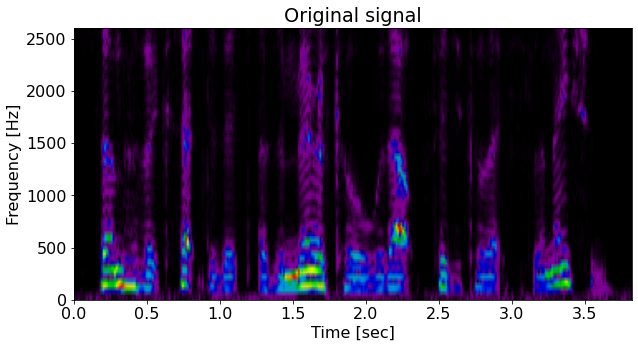

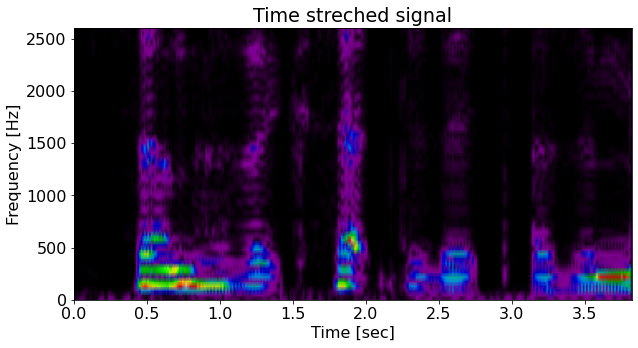

In [7]:
speech_streched_OLA = OLA_stretch(speech_sample, 0.4)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(speech_streched_OLA[:speech_sample.size], fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Time streched signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("time_stretch.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_streched_OLA, "samples/speech_streched_OLA.wav")

### 2.2. Pitch scaling

To achieve pitch scaling, we can simply combine time stretching and pitch control. For instance, by stretching the recording by some ratio, and then pitch controling the recording back to its original length 8and increasing its pitch), we end up with a recording of same length and higher pitch! The opposite process is also achievable the same way. Note it is possible to computationally optimize this process by setting that the order between the 2 transformations (streching and controlling) is different based on if we want to increase or decrease the pitch, simply in order to minimize the number of computations.

Let's implement a pitch scaling algorithm that takes as argument a time stretching algorithm, and combines it with pitch control.

In [8]:
def pitch_scale(x, r, stretch_algo, w=2048, h=512):
    """
    Pitch-scaler using a combination of time stretch and pitch control.
    x: the input signal
    r: the pitch change ratio
    strectch_algo: a python function computing a time stretched version of the signal
    w: the windows size of the stretching algori
    h: the hop size of the streching algorithm
    """
    # We use a different combination order depending on the ratio, in order to always deal with the shorter signals and gain time.
    if(r>=1): # When the ratio>1, pitch-control up first, to get a shorter signal, and then stretch it longer.
        return stretch_algo( pitch_control(x, r), 1/r, w, h)
    else: # When the ratio<1, start by streching the signal shorter, and then pitch-control it down.
        return pitch_control( stretch_algo(x, 1/r, w, h), r)

Let's now test out our OLA pitch scaling algorithm! Again, we can hear some artifact. The STFT plot however shows a vertical stretching while keeping the horizontal axis untouched. We are on the right way!

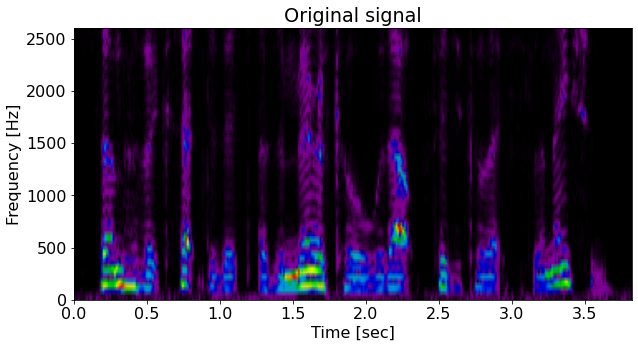

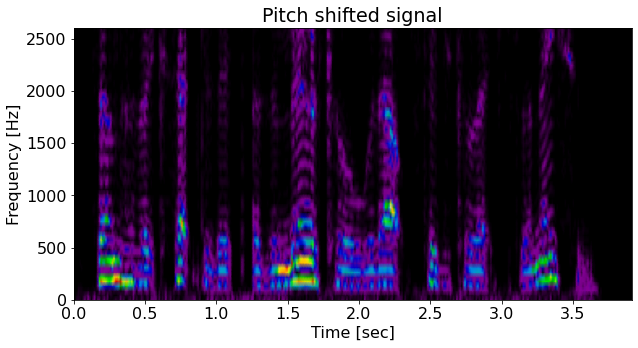

In [9]:
speech_pitched_OLA = pitch_scale(speech_sample, 1.3, OLA_stretch, w=4096, h=2048)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(speech_pitched_OLA, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch shifted signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("time_scale.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_pitched_OLA, "samples/speech_pitched_OLA.wav")

## 3. Phase vocoder

To improve the quality of the stretching and reduce the artifact problem, we must go in the frequency domain. Actually, the main source of the artifact audible in the OLA algorithm is that the phase of the beginning of each chunk matches the phase of the end of each chuck when using the analysis hop size only. When changing the hop size, we temporally displace the chunks and make them match to other of the neighbouring chucks, where the phase is not the same. These phase jumps while transitionning from a chunk to the other (although being slightly smoothed out by the window shape) are the cause for the artifacts.

A **phase vocoder** does exactly solve this problem. It cuts the input signal into chunks, and using a FFT, computes the magnitude and phase of each chunk. Then, it changes the hop size just like OLA did, but this time replaces the phase of each chunk so that it matches the phase of the previous chunk the way they now overlap. The magnitude is kept the same. Each chunk is then reverted to time domain before being added together.

<img src="https://i.imgur.com/9h0X2cw.png" alt="Drawing" style="width: 85%;"/>

### 3.1 Time stretching

Let's now implement the time streching effect using a Phase Vocoder. This time, we need to take 2 consecutive chunks at the time, in order to compute the phase difference between them. One variable is kept throughout the whole process to store what we call the **global phase** to which we will add the phase difference between the consecutive chunks at each iteration. This global phase will then replace the second chunk's phase. Let's start by implementing an algorithm that, taking 2 chunks and the current global phase, replaces the second chunk's phase and returns the updated second chunk and global phase.

In [10]:
def phase_correction(chunk1, chunk2, global_phase, w):
    """
    Chunk phase correction using a phase vocoder
    chunk1: the first chunk simply used to compute the phase difference
    chunk2: the second chunk that we are working on
    global_phase: the recomputed global phase to this point
    w: a window (not just its size, the window itself)
    return: chunk2 with corrected phase
    """
    # Analysis section (go to freq-domain and obtain the frequencies of the chucks)
    freqs1 = fft(w * chunk1)
    freqs2 = fft(w * chunk2)

    # Frequency-domain transformation
    instant_phase =  np.angle(freqs2/freqs1) # Difference between the 2 chunks' phases
    global_phase += instant_phase # Add diff to the global phase
    freqs2_rephased = np.abs(freqs2) * np.exp(1j*global_phase) # Replace chunk2's phase with the new one

    # Synthesis section (chunk2 back to time-domain)
    return np.real(ifft( freqs2_rephased )), global_phase

We can now integrate that phase vocoder correction algorithm back in our OLA implementation from before, using the same windowing loop. This time, we simply need to initiate a new variable for the global phase, and keep track of 2 chunks at the time. The rest is identical.

In [11]:
def PV_stretch(x, r, w=2048, h_in=512):
    """
    Time strech using a phase vocoder (Inspired from an implementation by Zulko: http://zulko.github.io)
    x: input signal
    r: time modification ratio
    w: window size
    h_in: input hop size (samples between 2 windows' start times)
    """
    phase  = np.zeros(w) # Init global phase
    hanning_window = np.hanning(w) # We use a hanning window
    result = np.zeros( int(x.size/r + w)) # Output placeholder

    # Windowing the signal with input hop size
    for i in np.arange(0, x.size-(w+h_in), int(h_in*r)):

        # Get 2 chunks at the time
        chunk1 = x[i: i + w]
        chunk2 = x[i + h_in: i + w + h_in]

        # Phase vocoder correction
        chunk2, phase = phase_correction(chunk1, chunk2, phase, hanning_window)

        # Overlap-add section (with different hop size)
        h_out = int(i/r) # output hop size
        result[h_out : h_out + w] += hanning_window * chunk2 # Add this window to result

    return result / np.max(np.abs(result) ) # Normalize

Time to try out this implementation. It sounds much better! The phase correction allowed us to use a shorter hop size and the artifact is now gone. You can try to remove the phase correction in the algorithm and notice how terrible it becomes.

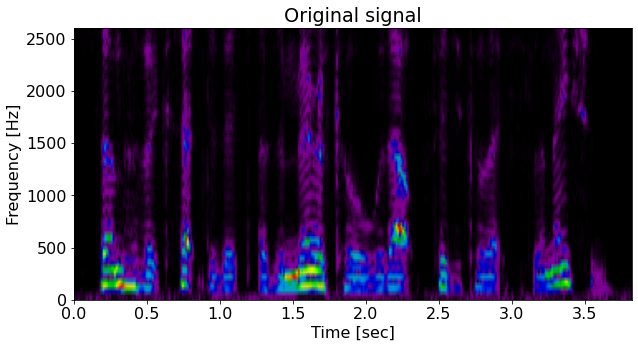

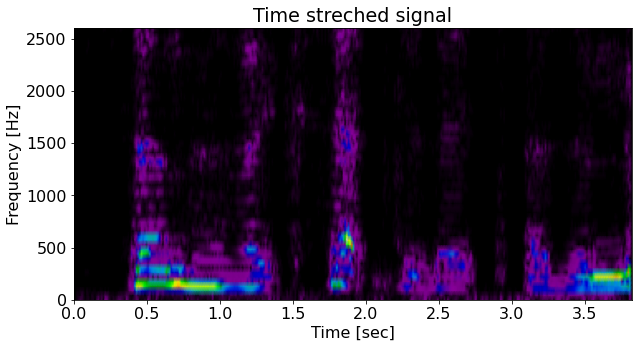

In [12]:
speech_streched_PV = PV_stretch(speech_sample, 0.4)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(speech_streched_PV[:speech_sample.size], fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Time streched signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("time_stretch.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_streched_PV, "samples/speech_streched_PV.wav")

### 3.2. Pitch scaling

Similarly as before, we can straight-forwardly get a pitch scaler using the function we implemented before, and simply passing it the phase vocoder version of the time stretching algorithm!

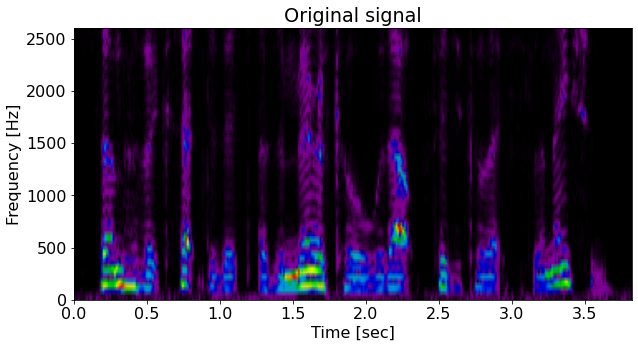

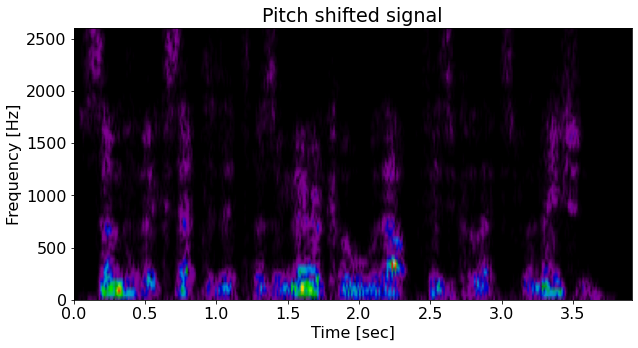

In [13]:
speech_pitched_PV = pitch_scale(speech_sample, .5, PV_stretch)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(speech_pitched_PV, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch shifted signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("time_scale.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_pitched_PV, "samples/speech_pitched_PV.wav")

### 3.3. Phase vocoder effects: robotization and whispering

Still using the phase vocoder, it is also possible implement some aesthetical effects! By setting the phase of each chunk to a random value, the pitch spreads in the frequencies in all directons, a little bit like the white noise produced when we whisper. Alternatively, by setting the phase of all chunks to 0, the pitch becomes constant, giving the voice a robotic colour. Let's try out!

In [14]:
def PV_fx(x, w=2048, h=512, fx="robot"):

    hanning_window = np.hanning(w) # We use a hanning window
    result = np.zeros(x.size) # Output placeholder

    # Windowing the signal 
    for i in np.arange(0, x.size-w, h):

        # Get chunk
        chunk = x[i: i + w]

        # Analysis section (go to freq-domain and obtain the frequencies of the chucks)
        freqs = fft(hanning_window * chunk)
        
        # Frequency-domain transformation
        if(fx=="robot"):
            phase = 0
        if(fx=="whisper"):
            phase = np.random.random((w)) * 2 * np.pi
        
        freqs_rephased = np.abs(freqs)*np.exp(1j*phase) # Replace chunk's phase with this new one
        
        # Synthesis section (back to time-domain)
        chunk_rephased = np.real(ifft( freqs_rephased ))

        # Overlap-add section (with different hop size)
        result[i : i + w] += hanning_window * chunk_rephased # Add this window to result

    return result / np.max(np.abs(result) ) # Normalize

In [15]:
speech_whisper_PV = PV_fx(speech_sample, w=256, h=64, fx="whisper")
write_audio(speech_whisper_PV, "samples/speech_whisper_PV.wav")

In [16]:
speech_robot_PV = PV_fx(speech_sample, w=1024, h=256, fx="robot")
write_audio(speech_robot_PV, "samples/speech_robot_PV.wav")

## 4. Formant preservation

The pitch scaling now works and has a smooth sound. There is however one thing that can be improved. When shifting a recording up or down, we not only shift each harmonic of the signal, but also their amplitudes, hence the global envelope (formant) of the signal. It is this shift of the formant that is responsible for making the pitched-shifted voice should like a chipmunk when shifted up, or like a ogre when shifted down. 

The next step in pitch-shifting is hence to keep the natural formant of the signal while shifting the harmomics. This way, although the pitch is transposed, the global color of the sound is preserved. This can be done using **Linear Predictive Coding  (LPC)**. While most details about the method are already presented in Dr. Prandoni's notebook linked above, let's summarize it quickly. The LPC method allows to remove the amplitude envelope of a signal, hence making its frequency response flat (only for the frequencies present in the signal). It is hence possible to get rid of the envelope and to add it (or another envelope) back later.

A dumb way of applying formant preservation to our phase vocoder algorithm, would be to first pitch shift the entire signal without formant preservation, and then, chunk by chunk, to remove the formant of the pitch shifted signal, and to instead add the formant of the original non pitch shifted signal. This way, the final signal is pitch shifted but still has the original formant. This method workds, however it is quite inneficient as it requires to loop of the signal 2 times in a row.

In [18]:
def pitch_scale_formant(x, r, w=2048, h=512, P=10):
    """
    Pitch-scaler using a combination of time stretch and pitch control, with formant preservation.
    x: the input signal
    r: the pitch change ratio
    strectch_algo: a python function computing a time stretched version of the signal
    w: the windows size of the stretching algorithm
    h: the hop size of the streching algorithm
    P: the numbers of parameters of the LPC estimation
    """    
    pitch_x = pitch_scale(x, r, PV_stretch) # Pitch scale the whole signal without formant preservation
    
    hanning_window = np.hanning(w) # We use a hanning window
    result = np.zeros(pitch_x.size) # Placeholder for the result
    
    # Iterate over both the original signal and the pitch scaled signal
    for i in np.arange(0, x.size-(w+h), int(h)):
        
        # Get a chunk of the original signal, and the pitch scaled signal
        chunk1 = x[i : i + w] # origial chunk
        chunk2 = pitch_x[i : i + w # pitch scaled chunk
         
        # Compute the LPC coefficients of each
        a1 = lpc(chunk1, P) # LPC original
        a2 = lpc(chunk2, P) # LPC pitch scaled
        
        # Replace the formant of the pitch scaled chunk with the original formant
        chunk2 = lfilter(a2, [1], chunk2) # remove pitch shifted formant
        chunk2 = lfilter([1], a1, chunk2) # add original formant
        
        # Overlap-and-add (OLA)
        result[i : i + w] += chunk2 * hanning_window
    
    return result / np.max(np.abs(result) ) # Normalize

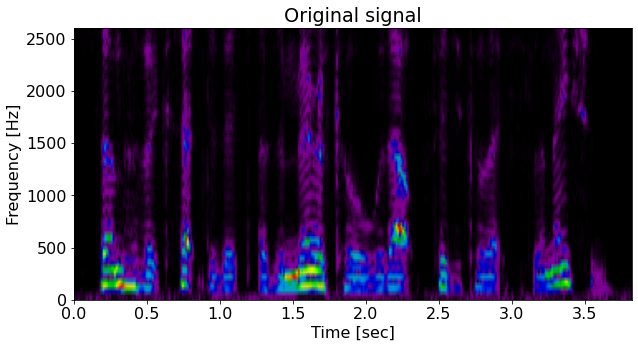

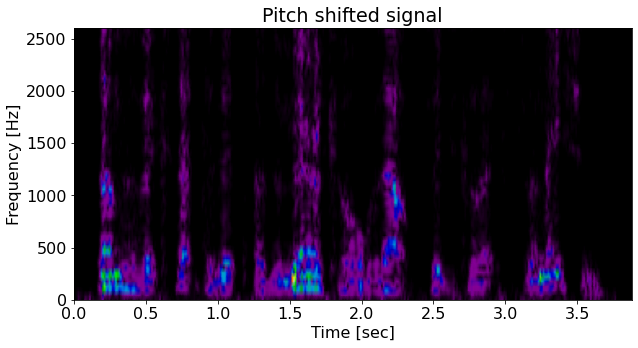

In [19]:
speech_pitched_LPC = pitch_scale_formant(speech_sample, .8, 2048, 512, P=20)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(speech_pitched_LPC, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch shifted signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("time_scale.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_pitched_LPC, "samples/speech_pitched_LPC.wav")

Let's finally move to a smarter implementation of this same algorithm. One can do the formant preservation in-place while doing the pitch shifting directly. However, this involves pitch shifting the signal chunk by chunk, instead of stretching it in a first time, and pitch controlling it in a second time. In this final implementation, we first phase correct the chunks, before a pitch-controlling each chunk with formant presevation. We then overlapp-and-add the chunks back together with the same hop size.

**TODO: check if this makes sense. it sounds less good than the other implementation ...**

In [21]:
def LPC_GS_pshift(x, r, w_in=2048, h=512, P=15):
    """
    Pitch-scaler in place, with formant preservation.
    x: the input signal
    r: the pitch change ratio
    strectch_algo: a python function computing a time stretched version of the signal
    w-in: the windows size of the stretching algorithm
    h: the hop size of the streching algorithm
    P: the numbers of parameters of the LPC estimation
    """    
    result = np.zeros(x.size) # Placeholder for output
    w_out = int(w_in/r) # Compute the window size after pitch control
    phase  = np.zeros(w_in) # Global phase init
    
    # Iterate over the chunks 2-by-2
    for i in np.arange(0, x.size-2*(w_out+h), int(h)): 
        
        # Get 2 chunks
        chunk1 = x[: w_in]
        chunk2 = x[i + h : i + w_in + h]
        
        # Phase correction using the phase vocoder
        chunk2, phase = phase_correction(chunk1, chunk2, phase, np.hanning(w_in))
        
        # Pitch control chunk by chunk (using LPC for preserving the formant)
        a = lpc(chunk2, P) # Compute the LPC coefficients
        e = lfilter(a, [1], chunk2, zi=chunk1[:P])[0] # Remove the formant envelope
        e = pitch_control(e, r) # Pitch control the "formant-less" chunk
        chunk2 = lfilter([1], a, e) # Re-add the formant envelope
        
        # Overlap-and-add (OLA)
        result[i : i + w_out] += chunk2 * np.hanning(w_out)
        
    return result / np.max(np.abs(result) ) # Normalize

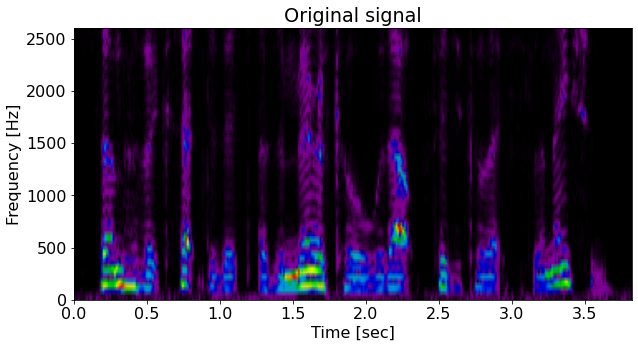

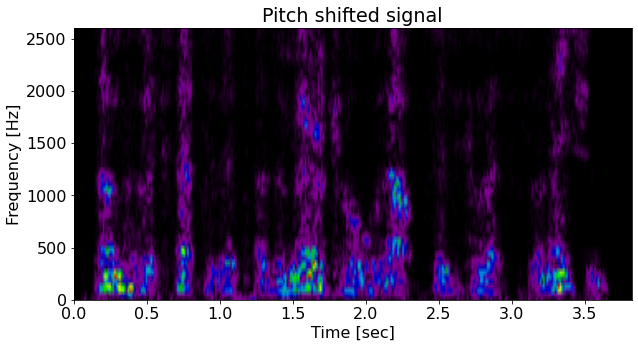

In [22]:
speech_pitched_LPC = LPC_GS_pshift(speech_sample, .8, 3000, 800, P=20)

# Plot
f, t, Zxx = signal.stft(speech_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(speech_pitched_LPC, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch shifted signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.savefig("time_scale.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
write_audio(speech_pitched_LPC, "samples/speech_pitched_LPC.wav")